In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%cd ..

/Users/rubenbroekx/Documents/Projects/radix-co2-reduction


# Tillage Classification - Random Forest

In [4]:
import json
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


from glob import glob
from collections import Counter
from pathlib import Path
from sklearn.metrics import confusion_matrix, f1_score

from src.radix_co2_reduction.tillage_detection.models import FieldRF

## Load Data

Load in all data used for the classification.

In [5]:
# Root data folder
DATA = Path.home() / 'data/agoro/2021-05-02'

In [6]:
# Fetch field-IDs
all_ids = glob(str(DATA / '*/ndti.png'))
all_ids = [int(i.split('/')[-2]) for i in all_ids]

In [7]:
# Load in all data
meta_data = {}
for i in all_ids:
    with open(DATA / f"{i}/meta.json", 'r') as f:
        meta_data[i] = json.load(f)
        
# Extract tillage types
tillage_types = {k:v['tillage'] for k,v in meta_data.items()}

# Get total number of fields
print(f"Total number of data samples:", len(tillage_types))

# Show classes
print(f"Number of samples by class:")
for k,v in Counter(tillage_types.values()).items():
    print(f" - {k}: {v}")

Total number of data samples: 628
Number of samples by class:
 - Conv.-Till: 309
 - No-Till: 319


In [8]:
N_TEST = 50

# Split into training and testing
no_till = [field_id for field_id,label in tillage_types.items() if label == 'No-Till']
conv_till = [field_id for field_id,label in tillage_types.items() if label == 'Conv.-Till']

# Test-set
test = no_till[:N_TEST] + conv_till[:N_TEST]
print(f"Test-size: {len(test)}")
train = no_till[N_TEST:] + conv_till[N_TEST:]
print(f"Train-size: {len(train)}")

Test-size: 100
Train-size: 528


## Train the Classifier

Train a Random Forest classifier on field-level data. 

In [9]:
# Load in and initialise the model
model = FieldRF(
    models_path=Path.cwd() / 'models',
)

Loaded existing cloud-filter!


In [10]:
# Train the model
model.train(
    field_ids=train,
    data_path=Path.home() / 'data/agoro/2021-05-02'
)

Processing: 100%|██████████| 528/528 [06:27<00:00,  1.36it/s]


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 91.99it/s]


Accuracy: 0.78
  Recall: 0.72
F1-score: 0.7659574468085107


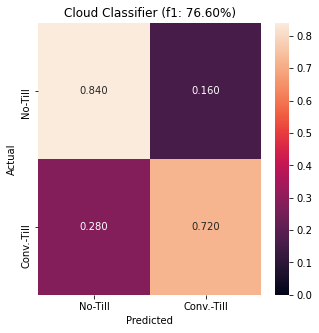

Misclassified
 - 104403
 - 93912
 - 103046
 - 71030
 - 67951
 - 79450
 - 80360
 - 80333
 - 57904
 - 94554
 - 102999
 - 79697
 - 79434
 - 70771
 - 79637
 - 80138
 - 94100
 - 57933
 - 102991
 - 102953
 - 103826
 - 102755


In [10]:
# Evaluate the model
true, preds = model.eval(
    field_ids=test,
    data_path=Path.home() / 'data/agoro/2021-05-02'
)

# Show confusion matrix
arr = confusion_matrix(true, preds, normalize='true')
plt.figure(figsize=(5, 5))
sns.heatmap(arr, annot=True, fmt=".3f", vmin=0)
title = f"Cloud Classifier (f1: {100*f1_score(true, preds):.2f}%)"
plt.title(title)
plt.xlabel("Predicted")
plt.xticks([0.5, 1.5], ['No-Till', 'Conv.-Till'])
plt.ylabel("Actual")
plt.yticks([0.5, 1.5], ['No-Till', 'Conv.-Till'])
plt.show()

# Print out the misclassified
print("Misclassified")
for i,l,p in zip(test,true,preds):
    if l != p:
        print(f" - {i}")

In [12]:
# Save the model
model.save()

In [13]:
# Example on inference
with open(Path.home() / 'data/agoro/2021-05-02/104403/samples/sentinel2.json', 'r') as f:
    sample = json.load(f)
print(f"Prediction on 104403 (should be False):", model(sample))

with open(Path.home() / 'data/agoro/2021-05-02/103077/samples/sentinel2.json', 'r') as f:
    sample = json.load(f)
print(f"Prediction on 103077 (should be True):", model(sample))

Unfolding data:   0%|          | 0/5 [00:00<?, ?it/s]

Prediction on 104403 (should be False): False


Unfolding data: 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

Prediction on 103077 (should be True): True
